In [1]:
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio

# Configure default pyplot settings
plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')


<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# The Inverse Discrete Fourier Transform

* **Course AIS2201 - Signalbehandling**
* **Uke 37, 2025**
* **Lecturer: Kai Erik Hoff**


## Recap: DFT of a sinusoid

Output()

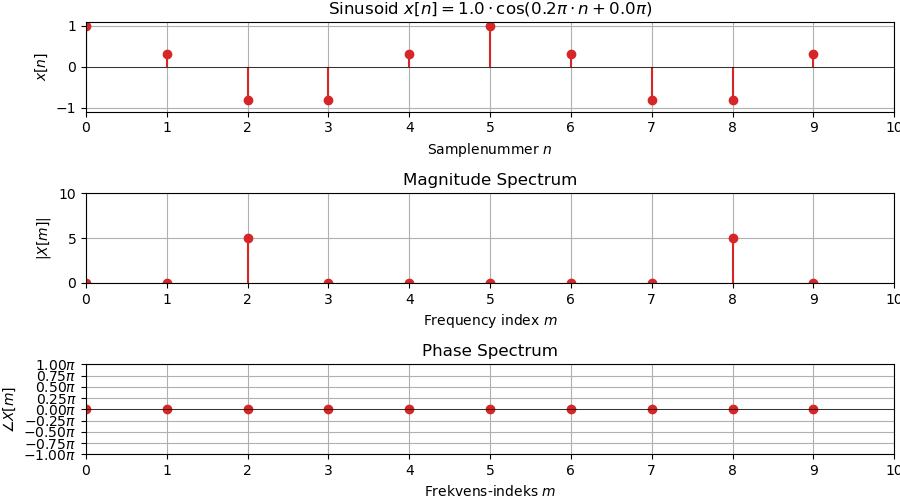

In [43]:
from demos import DFT_Demo
%matplotlib ipympl
DFT_Demo(2);

# The Inverse DFT (IDFT)

* Transformation of a sampled frequency spectrum $X[m]$ back to the discrete time domain $x[n]$.

* Equation:
$$x[n] = \frac{1}{N}\sum_{m=0}^{N-1}X[m]\cdot e^{j\cdot 2\pi \frac{m\cdot n}{N}} $$
Where $n$ is the sample number 
    
* Cumulative sum of all quadrature components which comrise the signal $x[n]$
* Important note: division by window length $N$ is erformed as part of the Inverse DFT

# `ifft` and `irfft`


* Algorithms for calculating the inverse fourier transform


* `ifft`: General inverse fourier transform for complex signals
    * Will provide complex data as output (even though the imaginary part is all zeroes)

* `irfft`: Optimized inverse fourier transform for real-valued signals
    * Real-valued output.
    * Assumes single-sided spectrum input of length $\frac{N}{2} + 1$
        * Best practice: always include signal length when using `rfft` and `irfft` in Python

## Code example:

Use `irfft` to generate $N=128$ samples o f the signal $x[n] = \sin\left(\frac{\pi}{32} \cdot n \right)$

<StemContainer object of 3 artists>

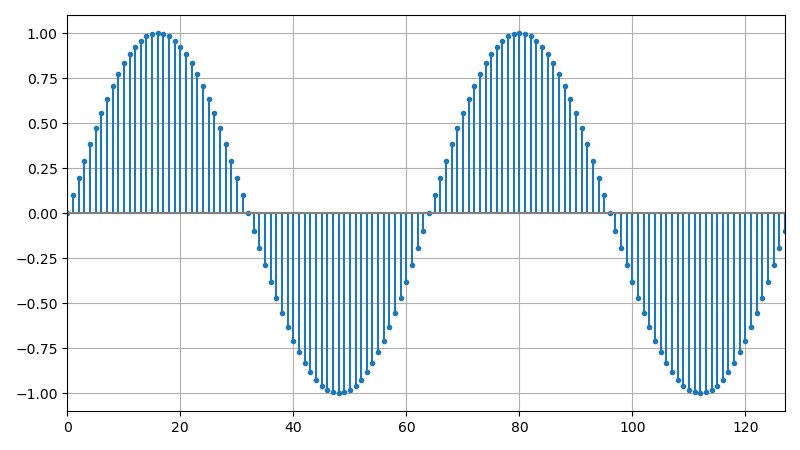

In [16]:
N = 128
n = np.arange(N)

Xm = np.zeros(N//2+1)+0j

Xm[2] = N/2j


xn = np.fft.irfft(Xm, N)
plt.close(2); plt.figure(2)
plt.stem(xn, markerfmt='.', basefmt='grey')

# Signal operations in the frequency domain

* Combining the DFT and IDFT opens the door to frequency-domain signal processing.

<img src="figures/Fig11_FreqProcessing.png" width="80%" />

# Scaling
|$\text{Frequency domain}$|$\text{Time domain}$|
|---|---|
|$Y[m] = X[m]\cdot \gamma$ | $y[n] = x[n]\cdot \gamma$|

*PS: for real-valued signals [rfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html) / [irfft](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft.html#numpy.fft.irfft) may be used.*

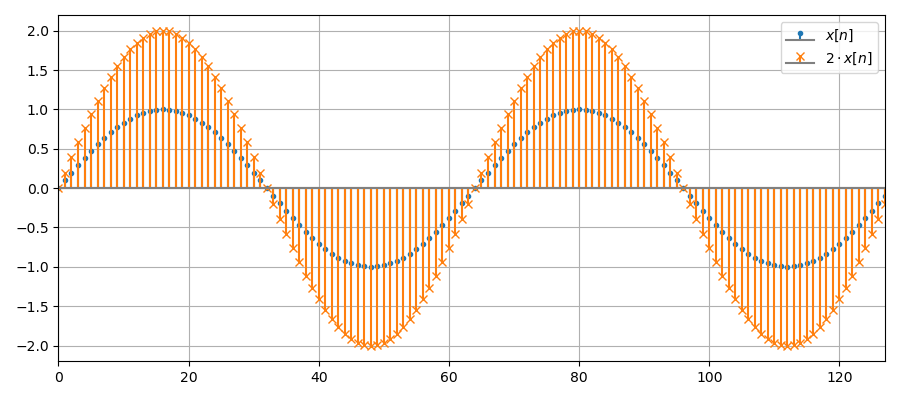

In [17]:
Xm = np.fft.rfft(xn) # xn fra forrige eksempel

scale_factor = 2
Ym = scale_factor*Xm

yn = np.fft.irfft(Ym) # Real IFFT


# Lag en figur med stolpediagram av både x[n] og y[n]
plt.close(3); plt.figure(3, figsize=(9, 4))
plt.stem(n, xn, basefmt='grey', label='$x[n]$', markerfmt='.')
plt.stem(n, yn, basefmt='grey', markerfmt='xC1', linefmt='C1', label='$2 \cdot x[n]$')
plt.legend()
plt.grid(True)

* The option of scaling the entire signal is not especially useful, although it is also possible to apply different scaling factors to different frequency components. This will work as a crude approach to filtering.

# Adjusting constant term
|$\text{Frekvensdomene}$|$\text{Tidsdomene}$|
|---|---|
|$Y[0] = X[0] + N \cdot \alpha$ | $y[n] = \alpha + x[n]$|


* Relevant use-case: DC removal!

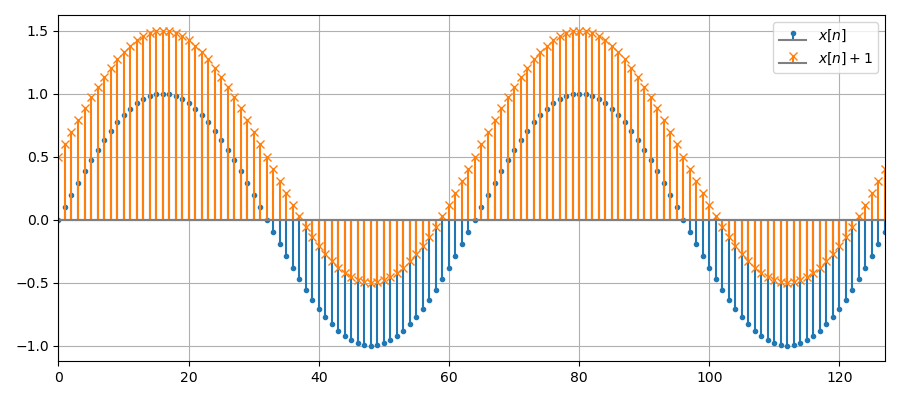

In [19]:
Xm = np.fft.rfft(xn)

Ym = Xm.copy()
Ym[0] += N*0.5

# Ym[0] = 0 vil "filtrere ut" konstantleddet

yn = np.fft.irfft(Ym, len(xn))

# Lag en figur med stolpediagram av både x[n] og y[n]
plt.close(4); plt.figure(4, figsize=(9, 4))
plt.stem(n, xn, basefmt='grey', label='$x[n]$', markerfmt=".")
plt.stem(n, yn, basefmt='grey', markerfmt='xC1', linefmt='C1', label='$x[n]+1$')
plt.legend()
plt.grid(True)

# Time-shifting the signal
|$\text{Frequency domain}$|$\text{Time domain}$|
|---|---|
|$Y[m] = X[m] \cdot e^{j\cdot 2\pi \cdot \frac{D}{N}\cdot m}$ | $y[n] = x[n+D]$|

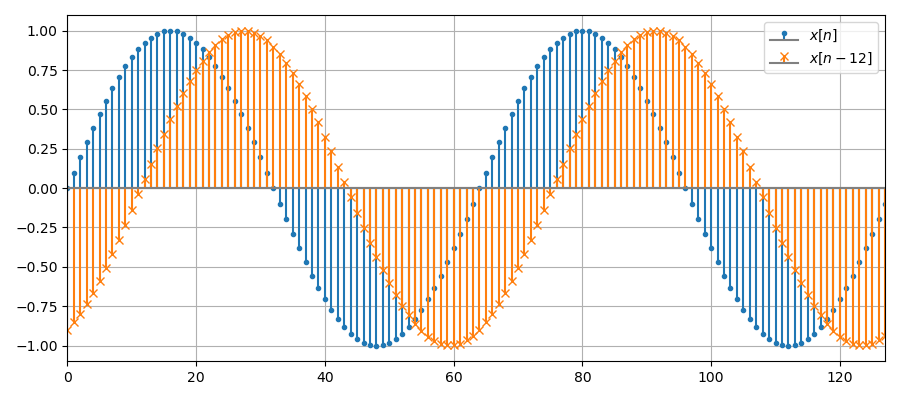

In [22]:
Xm = np.fft.rfft(xn)
m = np.arange(len(Xm))

Ym = Xm*np.exp(2j*pi*-11.4*m/N)

yn = np.fft.irfft(Ym)


# Lag en figur med stolpediagram av både x[n] og y[n]
plt.close(5); plt.figure(5, figsize=(9, 4))
plt.stem(n, xn, basefmt='grey', label='$x[n]$', markerfmt= '.')
plt.stem(n, yn, basefmt='grey', markerfmt='xC1', linefmt='C1', label='$x[n-12]$')
plt.legend()
plt.grid(True)

* Take note of how the time shifting of $x[n]$ is "circular" and the last 4 samples are moved to the start of the signal.

* Time shifting in the frequency domain will be relevant for filtering

# Crude approach to filtering

* It is possible to implement digital filters in the frequency domain
$$Y[m] = X[m]\cdot H[m]$$
    * Where the *frequency response* $H[m]$ may be a "binary masking array":
$$
H[m] = 
\begin{cases}
1,& \ \ \ \ \ \text{frequency components with frequency } \hat{\omega} > \hat{\omega}_m \text{ are to be preserved.}\\
0,& \ \ \ \ \ \text{frequency components with frequency } \hat{\omega} < \hat{\omega}_m \text{ are to be removed.}
\end{cases}
$$

array([0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 4.-3.28271516j, 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 4.-2.13804454j, 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 4.-1.21338673j, 0.+0.j        ,
       0.+0.j        , 0.+0.j        , 4.-0.39396561j, 0.+0.j        ,
       0.+0.j        ])

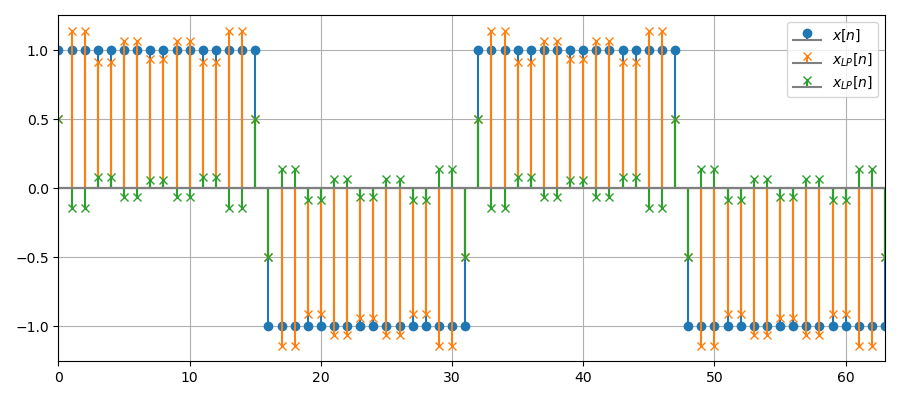

In [27]:
import scipy.signal as sig
# Lag 64 sampler av en firkantpuls der perioden er 32 sampler

N = 64
n = np.arange(0, N)
x_n = sig.square(2*pi*n/32)

# Ta DFT av firkantpulsen for å finne X[m]
X_m = np.fft.rfft(x_n)
m = np.arange(len(X_m))

m_cutoff = 16 # Kantfrekvens i indeks-form

H_lp = (m < m_cutoff)  # Lowpass
H_hp = (m >= m_cutoff) # Highpass

X_lp = X_m * H_lp
y_n = np.fft.irfft(X_lp)

X_hp = X_m * H_hp
y2_n = np.fft.irfft(X_hp)

# Lag en figur med stolpediagram av både x[n] og y[n]
plt.close(6); plt.figure(6, figsize=(9, 4))
plt.stem(n, x_n, basefmt='grey', label='$x[n]$')
plt.stem(n, y_n, basefmt='grey', markerfmt='xC1', linefmt='C1', label='$x_{LP}[n]$')
plt.stem(n, y2_n, basefmt='grey', markerfmt='xC2', linefmt='C2', label='$x_{LP}[n]$')
plt.legend()
plt.grid(True)

## Coding example: bandsplitting music

* The audio file `RockDrums-48-mono-11secs.wav` is sampled at a sampling rate $f_s = 44100$ samples per second. Separate the audio signal into frequency bands $0 \leq f < 2000$ and $f > 2000$.

In [42]:
from scipy.io import wavfile
fs, data = wavfile.read("data/RockDrums-48-mono-11secs.wav")
x_n = data/0x8000
N = len(x_n)


X_m = np.fft.rfft(x_n)
m = np.arange(len(X_m))


f_cutoff = 2000 # Hz
m_cutoff = N//(fs/f_cutoff) # Indeks for frekvenssample på avskjæringsfrekvensen


H1_m = (m<m_cutoff)
H2_m = (m>=m_cutoff)

Y_LP = X_m*H1_m # Lavpassfiltrert signal
Y_HP = X_m*H2_m # Høypassfiltrert signal

# Sett sammen lyd med ulik skalering av lavpassfiltret og høypassfiltrert bånd

y_LP = np.fft.irfft(Y_LP)
y_HP = np.fft.irfft(Y_HP)

**Play Audio:**

In [38]:
from IPython.display import Audio
Audio(y_random, rate=fs)

## Questions?